#### Imports

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import random
from time import time

%matplotlib inline

#### Import Data

In [2]:
with np.load("notMNIST.npz") as data:
    images, labels = data["images"], data["labels"]

In [3]:
num_classes = labels.max() - labels.min() + 1
num_classes

10

In [4]:
images.shape

(28, 28, 18720)

In [5]:
images.T.shape

(18720, 28, 28)

In [6]:
labels.shape

(18720, 1)

In [7]:
temp_img = images.T[1].T
temp_img.shape

(28, 28)

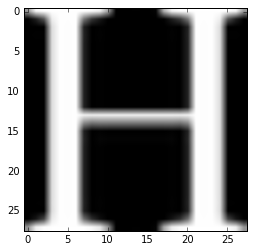

In [8]:
plt.imshow(temp_img, cmap=plt.gray())

In [9]:
print labels[1]

[7]


## Logistic Regression w/ Softmax

- Softmax output layer
- Log likelihood objective function
- Train with no reg., SGD and momentum
- Find good value for momentum hyper
- Plot log likelihood / errors of training and valid vs number of epochs
- Determine best time to stop training, and compute test errors on it

$$y(\mathbf{x}, \mathbf{w}) = \sigma (\mathbf{x}^T \mathbf{w} + b)$$

#### Set up data

In [10]:
images_re = images.reshape((images.shape[0] * images.shape[1], images.shape[2])).T
images_re.shape

(18720, 784)

In [11]:
training_size = 15000
validation_size = 1000

In [12]:
train_x = images_re[:training_size]
valid_x = images_re[training_size:training_size + validation_size]
test_x = images_re[training_size + validation_size:]

#### Create one-hot labels

In [18]:
labels.shape

(18720, 1)

In [14]:
labels[:10]

array([[4],
       [7],
       [5],
       [9],
       [9],
       [1],
       [0],
       [8],
       [5],
       [5]], dtype=uint8)

In [19]:
num_examples = labels.size
labels_one_hot = np.zeros((num_examples, labels.max() - labels.min() + 1))
labels_one_hot[np.arange(num_examples), labels.ravel()] = 1

In [20]:
labels_one_hot[:10]

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [24]:
train_y = labels_one_hot[:training_size]
valid_y = labels_one_hot[training_size:training_size + validation_size]
test_y = labels_one_hot[training_size + validation_size:]

### Task 1

#### Set up TF variables

In [31]:
image_pixels = 28 * 28

In [32]:
#Placeholders
X = tf.placeholder("float", shape=(None, image_pixels))
Targets = tf.placeholder("float", shape=(None, num_classes))

#Variables
W = tf.Variable(np.random.randn(image_pixels, num_classes).astype("float32"), name="weight")
b = tf.Variable(np.random.randn(num_classes).astype("float32"), name="bias")

In [33]:
logits = tf.add(tf.matmul(X, W), b)
Y = tf.nn.softmax(logits)

In [34]:
Y.get_shape()

TensorShape([Dimension(None), Dimension(10)])

#### Using CE loss function

In [35]:
cost_batch = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Targets)
cost = tf.reduce_mean(cost_batch)

In [36]:
learning_rate = 0.0001
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.01)
train_op = optimizer.minimize(cost)

In [37]:
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

In [38]:
correct_prediction.get_shape()

TensorShape([Dimension(None)])

In [39]:
sess = tf.InteractiveSession()

#### Step 1: Determine mini-batch size

In [91]:
num_epochs = 150

In [96]:
for mini_batch_size in [50, 100, 500]:
    init = tf.initialize_all_variables()
    sess.run(init)
    
    for epoch in range(num_epochs): 
        for i in range(training_size / mini_batch_size):
            batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
            batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

            _cost, _ = sess.run([cost, train_op], feed_dict={X: batch_x, Targets: batch_y})
    
    print mini_batch_size, sess.run([accuracy], feed_dict={X: valid_x, Targets: valid_y})

50 [0.82599998]
100 [0.82800001]
500 [0.82200003]


Choose a mini-batch size of 100

#### Step 2: Determine learning rate

In [97]:
num_epochs = 150
mini_batch_size = 100

In [98]:
for learning_rate in [0.00001, 0.0001, 0.001]:
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.01)
    train_op = optimizer.minimize(cost)

    init = tf.initialize_all_variables()
    sess.run(init)
    
    for epoch in range(num_epochs): 
        for i in range(training_size / mini_batch_size):
            batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
            batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

            _ = sess.run([train_op], feed_dict={X: batch_x, Targets: batch_y})
    
    print learning_rate, sess.run([accuracy], feed_dict={X: valid_x, Targets: valid_y})

1e-05 [0.78500003]
0.0001 [0.82800001]
0.001 [0.83600003]


Choose a learning rate of 0.001

#### Step 3: Determine Momentum

In [99]:
learning_rate = 0.001
num_epochs = 150
mini_batch_size = 100

In [100]:
for momentum in [0.001, 0.01, 0.1]:
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
    train_op = optimizer.minimize(cost)

    init = tf.initialize_all_variables()
    sess.run(init)
    
    for epoch in range(num_epochs): 
        for i in range(training_size / mini_batch_size):
            batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
            batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

            _ = sess.run([train_op], feed_dict={X: batch_x, Targets: batch_y})
    
    print momentum, sess.run([cost, accuracy], feed_dict={X: valid_x, Targets: valid_y})

0.001 [153.92221, 0.838]
0.01 [153.34132, 0.83600003]
0.1 [151.61499, 0.84500003]


Choose a momentum of 0.1

#### Step 4: Plot Number of Errors and Log Likelihood, then determine best time to stop training 

In [101]:
num_epochs = 250
mini_batch_size = 100
epochs_per_evaluation = 10
learning_rate = 0.0001
momentum = 0.1

In [102]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
train_op = optimizer.minimize(cost)

In [103]:
init = tf.initialize_all_variables()
sess.run(init)

In [104]:
train_accuracy = []
train_cost = []
valid_accuracy = []
valid_cost = []

In [105]:
for epoch in range(num_epochs): 
    for i in range(training_size / mini_batch_size):
        batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
        batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

        _ = sess.run([train_op], feed_dict={X: batch_x, Targets: batch_y})
        
    # Evaluate every 10 epochs
    if 0 == (epoch % epochs_per_evaluation):
        cost_train, accuracy_train = sess.run([cost, accuracy], feed_dict={X: train_x, Targets: train_y})
        cost_valid, accuracy_valid = sess.run([cost, accuracy], feed_dict={X: valid_x, Targets: valid_y})

        train_cost.append(cost_train)
        train_accuracy.append(accuracy_train)

        valid_cost.append(cost_valid)
        valid_accuracy.append(accuracy_valid)   

In [106]:
train_num_errors = np.around((1 - np.array(train_accuracy)) * training_size)

In [113]:
train_accuracy[-1]

0.86793333

In [107]:
valid_num_errors = np.around((1 - np.array(valid_accuracy)) * validation_size)

In [114]:
valid_accuracy[-1]

0.82800001

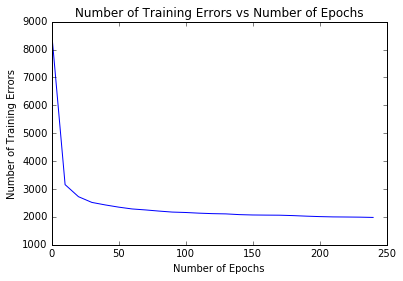

In [108]:
plt.title("Number of Training Errors vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Number of Training Errors")
plt.plot(np.arange(len(train_num_errors)) * epochs_per_evaluation, train_num_errors)

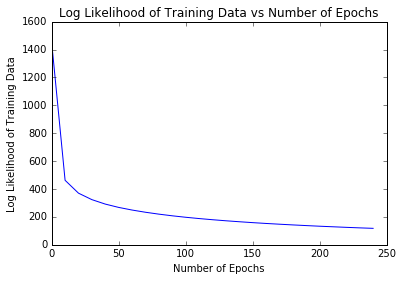

In [109]:
plt.title("Log Likelihood of Training Data vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Log Likelihood of Training Data")
plt.plot(np.arange(len(train_cost)) * epochs_per_evaluation, train_cost)

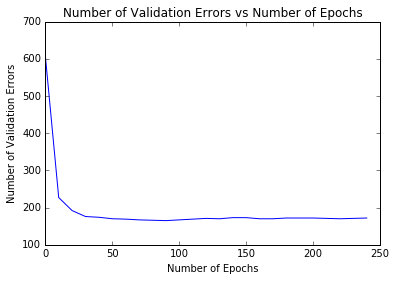

In [110]:
plt.title("Number of Validation Errors vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Number of Validation Errors")
plt.plot(np.arange(len(valid_num_errors)) * epochs_per_evaluation, valid_num_errors)

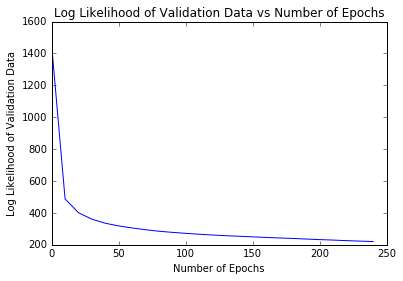

In [111]:
plt.title("Log Likelihood of Validation Data vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Log Likelihood of Validation Data")
plt.plot(np.arange(len(valid_cost)) * epochs_per_evaluation, valid_cost)

It can be seen that the validation error starts increasing slightly around 100 epochs, so we will stop training there, and evaluate on the the test set

#### Step 5: Train model for desired number of epochs and compute test accuracy

In [115]:
num_epochs = 100
init = tf.initialize_all_variables()
sess.run(init)

In [116]:
for epoch in range(num_epochs): 
    for i in range(training_size / mini_batch_size):
        batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
        batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

        _ = sess.run([train_op], feed_dict={X: batch_x, Targets: batch_y})

In [117]:
sess.run([cost, accuracy], feed_dict={X: test_x, Targets: test_y})

[275.34418, 0.82977939]

In [122]:
print "Number of test errors: ", round((1 - 0.82977939) * len(test_y))

Number of test errors:  463.0


In [123]:
sess.close()

### Neural Network
- RELU activation function
- softmax for output layer
- Cross entropy (log likelihood) as cost function

##### Helper functions

In [124]:
def weight_var(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_var(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Task 2: One hidden layer of 1000 units

In [130]:
hidden_units = 1000

In [131]:
X_nn = tf.placeholder("float", shape=(None, image_pixels))
Targets_nn = tf.placeholder("float", shape=(None, num_classes))

In [132]:
Targets_nn.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [133]:
W1_nn = weight_var([image_pixels, hidden_units])
W2_nn = weight_var([hidden_units, num_classes])
b1_nn = bias_var([hidden_units])
b2_nn = bias_var([num_classes])

In [134]:
H_nn = tf.nn.relu(tf.matmul(X_nn, W1_nn) + b1_nn)
logits_nn = tf.matmul(H_nn, W2_nn) + b2_nn
Y_nn = tf.nn.softmax(logits_nn)

In [135]:
Y_nn.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [136]:
cost_batch_nn = tf.nn.softmax_cross_entropy_with_logits(logits=logits_nn, labels=Targets_nn)
cost_nn = tf.reduce_mean(cost_batch_nn)

In [137]:
correct_prediction_nn = tf.equal(tf.argmax(Y_nn, 1), tf.argmax(Targets_nn, 1))
accuracy_nn = tf.reduce_mean(tf.cast(correct_prediction_nn, "float32"))

In [138]:
sess_nn = tf.InteractiveSession()

In [142]:
num_epochs = 30
num_epochs_per_eval = 2

In [143]:
dict_per_learn_rate = []
for learning_rate_nn in [0.0001, 0.0005, 0.001, 0.01, 0.1]:
    
    print learning_rate_nn
    _dict = {"train_cost": [], "train_acc": [], "valid_cost": [], "valid_acc": []}
    
    optimizer_nn = tf.train.GradientDescentOptimizer(learning_rate_nn)
    train_op_nn = optimizer_nn.minimize(cost_nn)

    init_nn = tf.initialize_all_variables()
    sess_nn.run(init_nn)

    for epoch in range(num_epochs):
        _ = sess_nn.run([train_op_nn], feed_dict={X_nn: train_x, Targets_nn: train_y})

        if 0 == (epoch % num_epochs_per_eval):
            cost_per_epoch, acc_per_epoch = sess_nn.run([cost_nn, accuracy_nn], feed_dict={X_nn: train_x, Targets_nn: train_y})
            _dict["train_cost"].append(cost_per_epoch)
            _dict["train_acc"].append(acc_per_epoch)

            cost_per_epoch, acc_per_epoch = sess_nn.run([cost_nn, accuracy_nn], feed_dict={X_nn: valid_x, Targets_nn: valid_y})
            _dict["valid_cost"].append(cost_per_epoch)
            _dict["valid_acc"].append(acc_per_epoch)
            
    print cost_per_epoch, acc_per_epoch
    
    dict_per_learn_rate.append(_dict)

0.0001
79.3404 0.769
0.0005
42.9413 0.837
0.001
28.7797 0.815
0.01
3.64383 0.187
0.1
2.44584 0.112


In [149]:
learning_rates = [0.0001, 0.0005, 0.001, 0.01, 0.1]

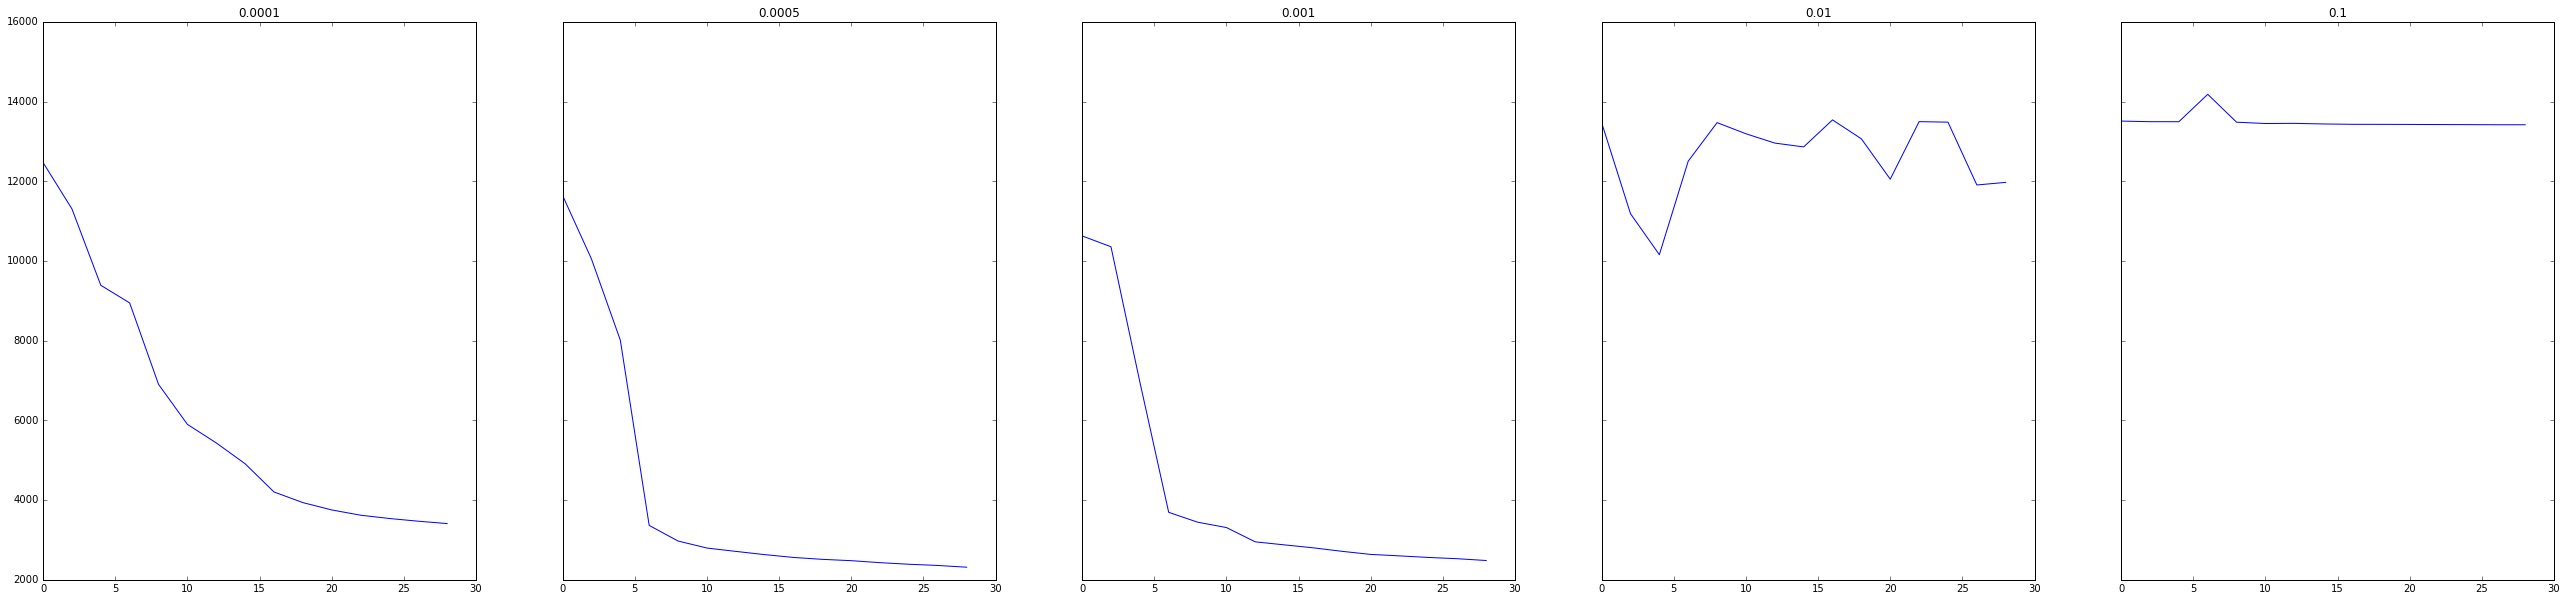

In [176]:
# Plot number of training errors
f, axarr = plt.subplots(1, 5, sharey=True)
f.set_figwidth(45)
f.set_figheight(10)
for i, x in enumerate(dict_per_learn_rate):
    axarr[i].set_title(learning_rates[i])
    axarr[i].plot(np.arange(len(x["train_acc"])) * num_epochs_per_eval, np.around(len(train_y) * (1 - np.array(x["train_acc"]))))

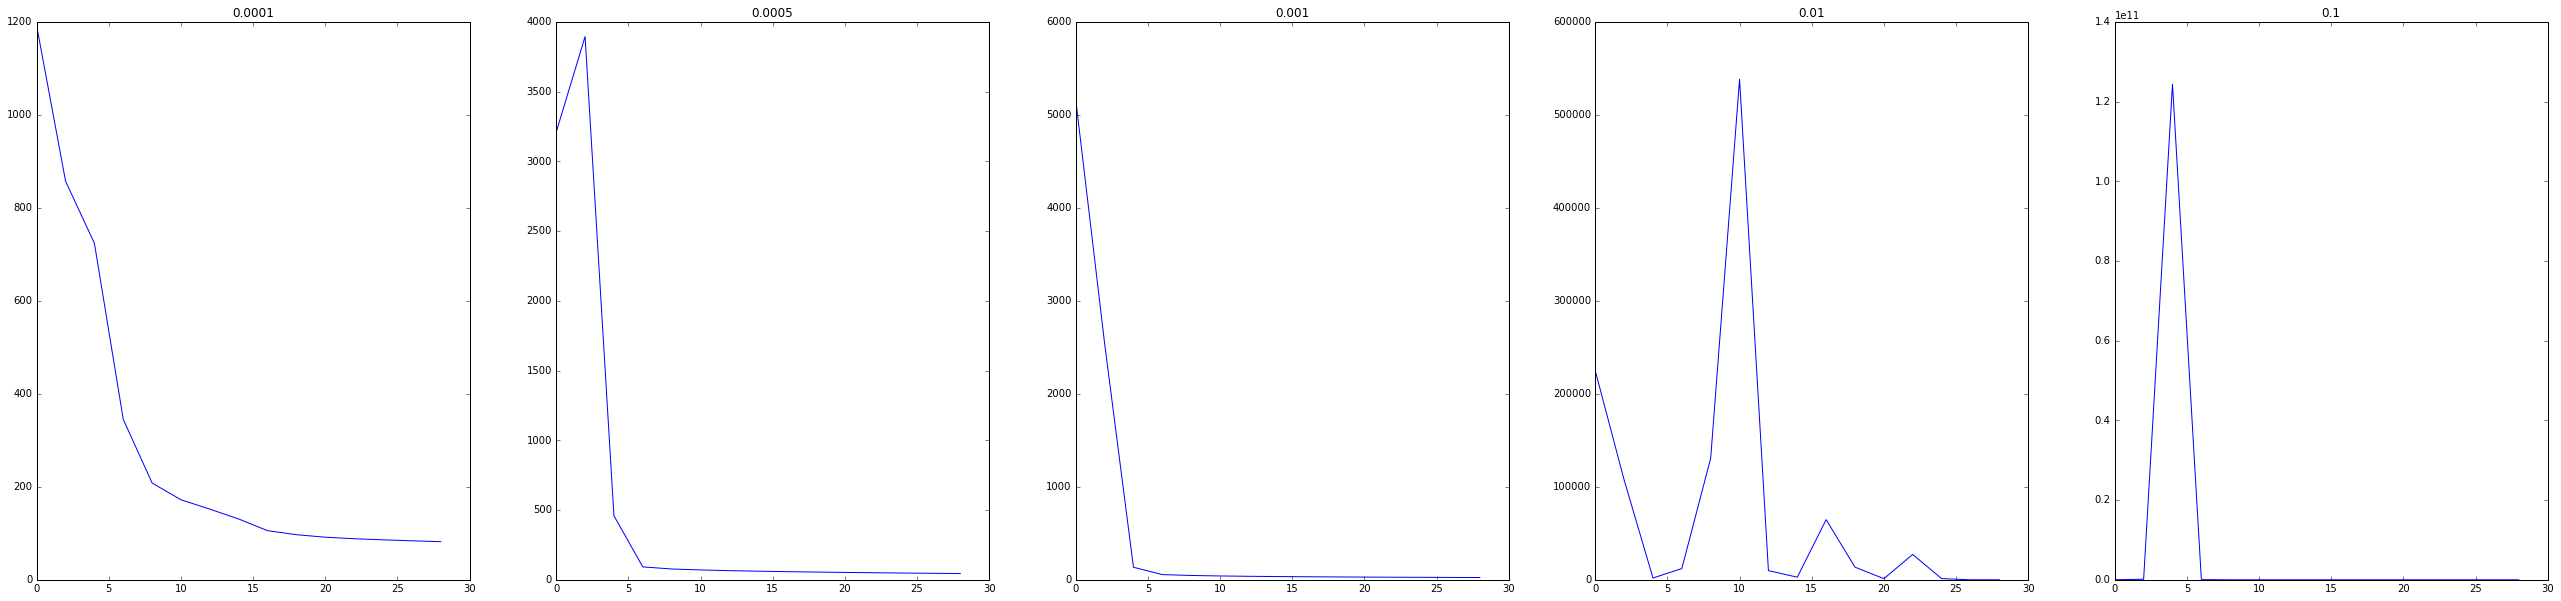

In [174]:
# Plot train cost
f, axarr = plt.subplots(1, 5)
f.set_figwidth(45)
f.set_figheight(10)
for i, x in enumerate(dict_per_learn_rate):
    axarr[i].set_title(learning_rates[i])
    axarr[i].plot(np.arange(len(x["train_cost"])) * num_epochs_per_eval, x["train_cost"])

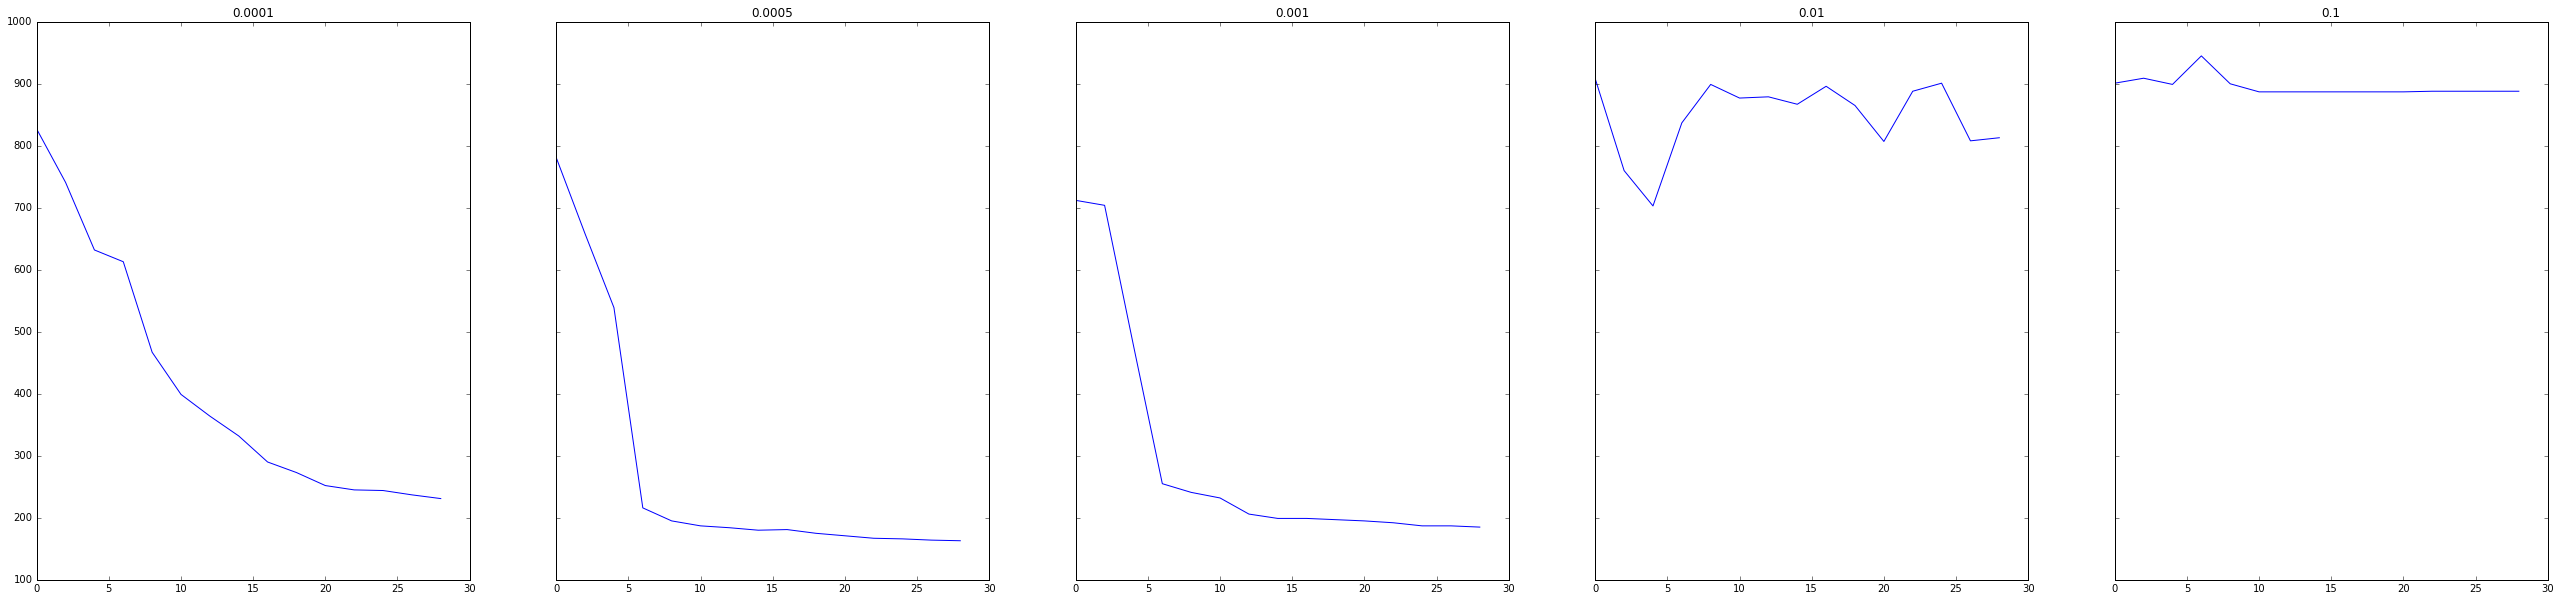

In [172]:
# Plot number of validation errors
f, axarr = plt.subplots(1, 5, sharey=True)
f.set_figwidth(45)
f.set_figheight(10)
for i, x in enumerate(dict_per_learn_rate):
    axarr[i].set_title(learning_rates[i])
    axarr[i].plot(np.arange(len(x["valid_acc"])) * num_epochs_per_eval, np.around(len(valid_y) * (1 - np.array(x["valid_acc"]))))

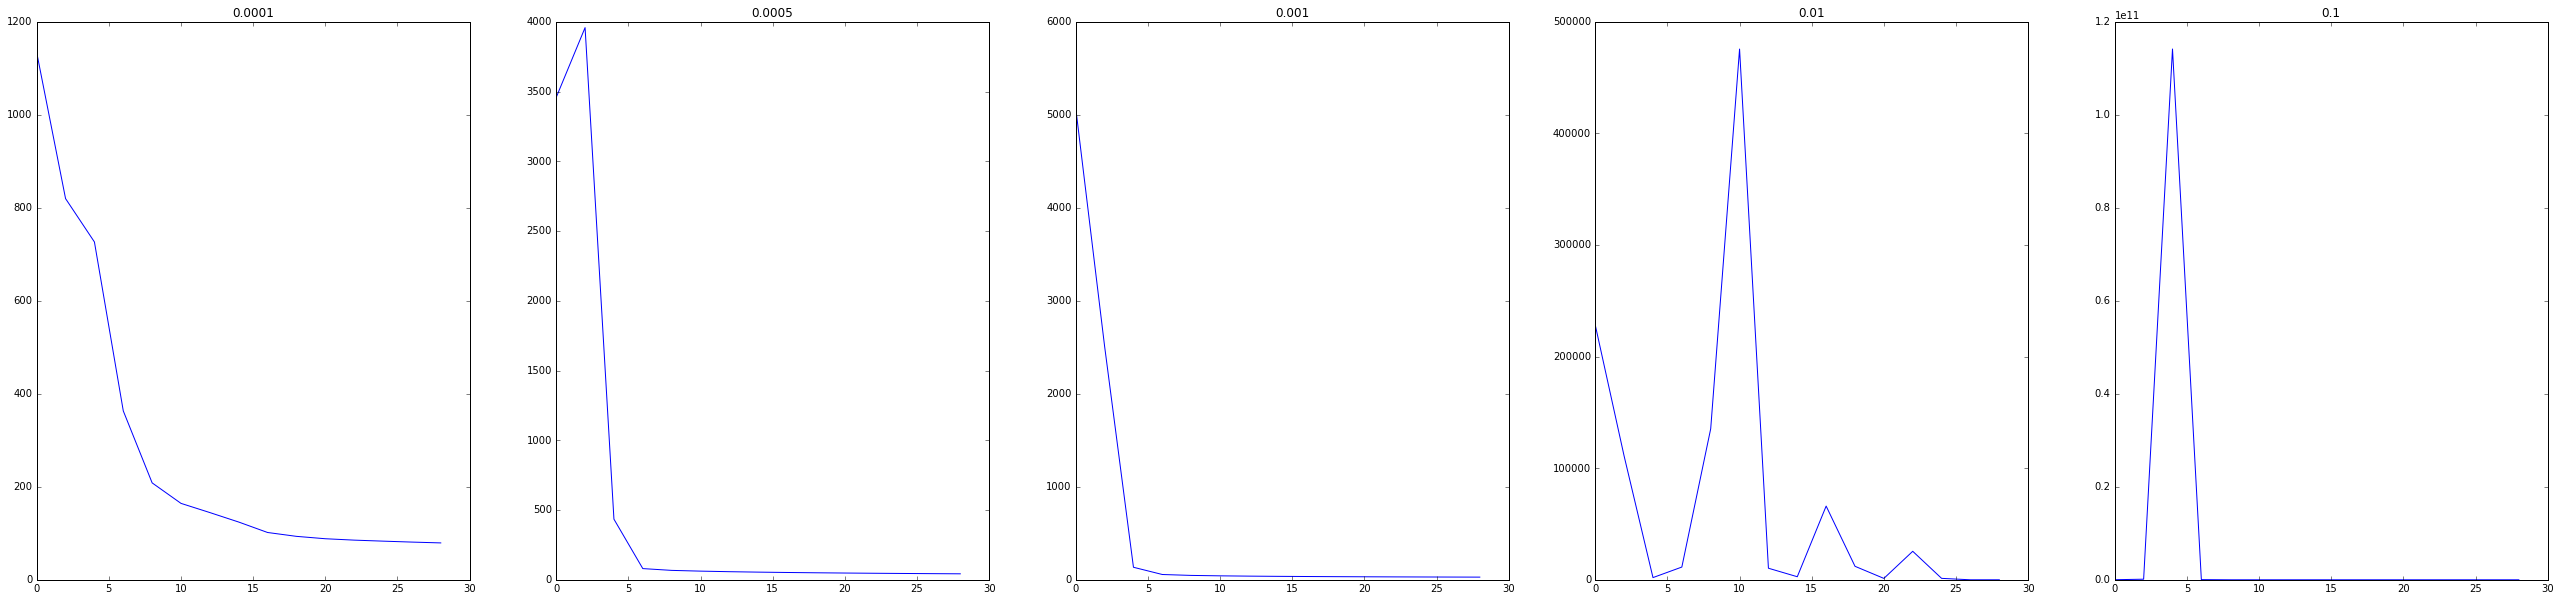

In [175]:
# Plot validation cost
f, axarr = plt.subplots(1, 5)
f.set_figwidth(45)
f.set_figheight(10)
for i, x in enumerate(dict_per_learn_rate):
    axarr[i].set_title(learning_rates[i])
    axarr[i].plot(np.arange(len(x["valid_cost"])) * num_epochs_per_eval, x["valid_cost"])

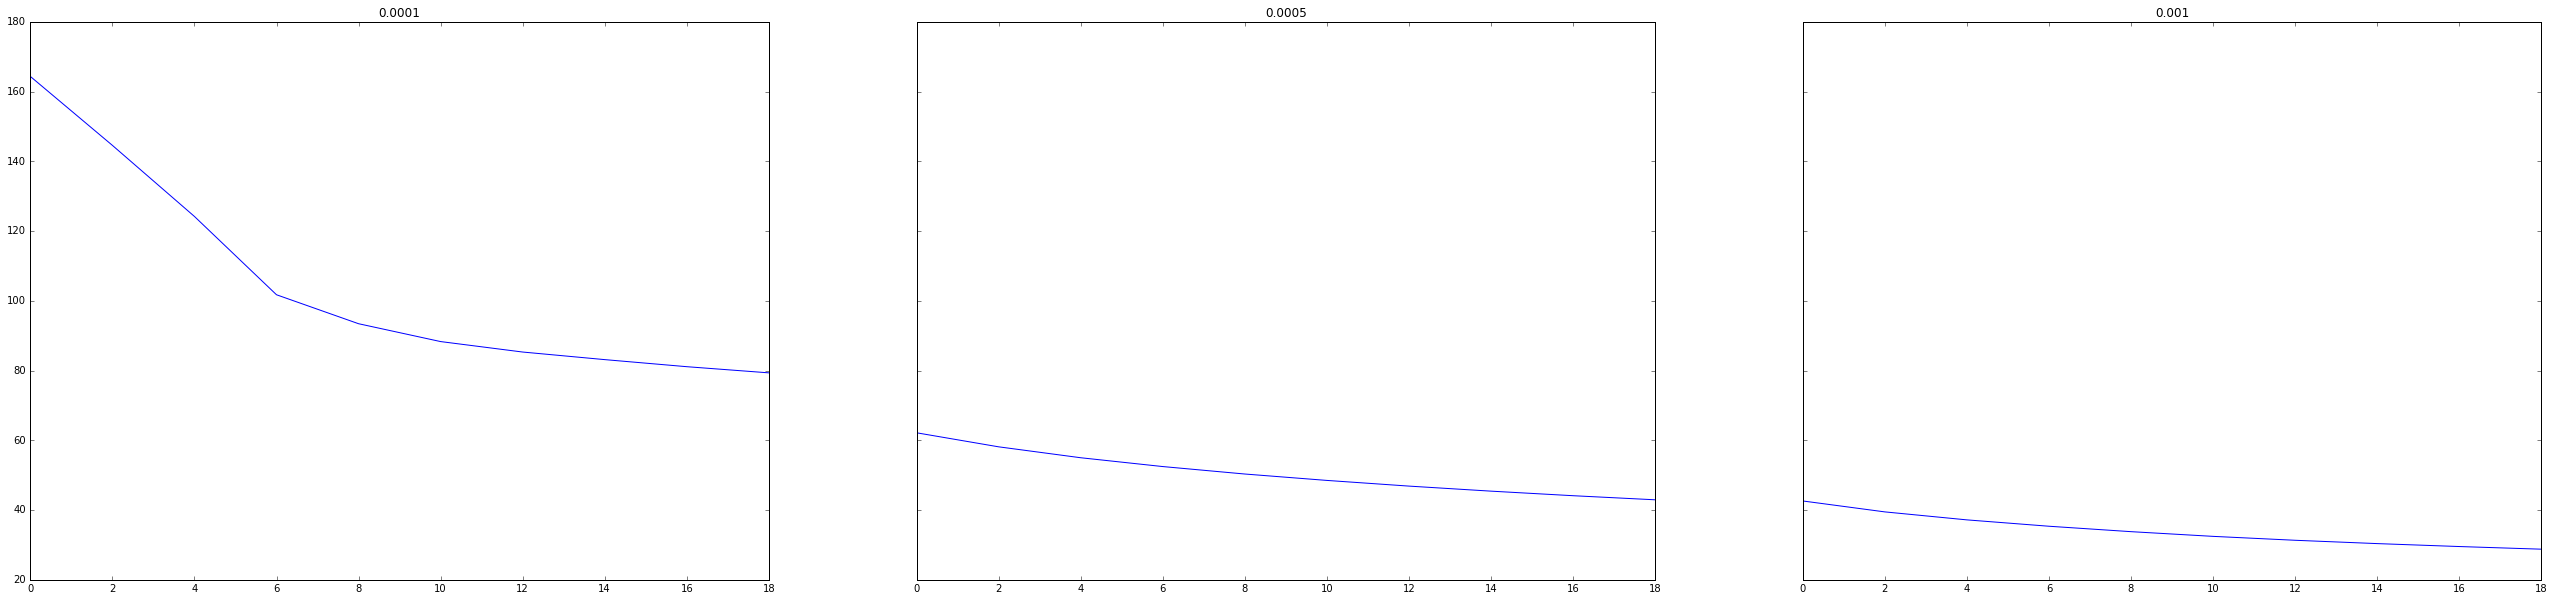

In [179]:
# Plot validation cost of just the first three learning rate, skipping the first 5 data points
f, axarr = plt.subplots(1, 3, sharey=True)
f.set_figwidth(45)
f.set_figheight(10)
for i, x in enumerate(dict_per_learn_rate[:3]):
    axarr[i].set_title(learning_rates[i])
    axarr[i].plot(np.arange(len(x["valid_cost"][5:])) * num_epochs_per_eval, x["valid_cost"][5:])

To choose the best model, we use the learning rate 0.001, as it has the lowest final log likelihood on the validation set.  We choose to keep number of epochs at 30, as this is where the validation cost has plateaued.

In [180]:
num_epochs = 30
learning_rate_nn = 0.001

In [181]:
optimizer_nn = tf.train.GradientDescentOptimizer(learning_rate_nn)
train_op_nn = optimizer_nn.minimize(cost_nn)

sess_nn.run(init_nn)

In [182]:
for epoch in range(num_epochs):
    _ = sess_nn.run([train_op_nn], feed_dict={X_nn: train_x, Targets_nn: train_y})

In [183]:
test_cost, test_acc = sess_nn.run([cost_nn, accuracy_nn], feed_dict={X_nn: test_x, Targets_nn: test_y})

In [186]:
print "Number of test errors: ", round((1 - np.array(test_acc)) * len(test_y)), " / ", len(test_y)

Number of test errors:  524.0  /  2720


### Task 3: Number of Hidden Units

In [ ]:
num_epochs = 30
num_epochs_per_eval = 2
learning_rate_nn = 0.001

In [ ]:
optimizer_nn = tf.train.GradientDescentOptimizer(learning_rate_nn)
train_op_nn = optimizer_nn.minimize(cost_nn)

In [ ]:
dict_per_hidden = []
for hidden_units in [100, 500, 1000]:
    
    print hidden_units
    _dict = {"valid_cost": [], "valid_acc": []}
    
    # Change these settings for each iteration
    W1_nn = weight_var([image_pixels, hidden_units])
    W2_nn = weight_var([hidden_units, num_classes])
    b1_nn = bias_var([hidden_units])

    init_nn = tf.initialize_all_variables()
    sess_nn.run(init_nn)

    for epoch in range(num_epochs):
        _ = sess_nn.run([train_op_nn], feed_dict={X_nn: train_x, Targets_nn: train_y})

        if 0 == (epoch % num_epochs_per_eval):
            cost_per_epoch, acc_per_epoch = sess_nn.run([cost_nn, accuracy_nn], feed_dict={X_nn: valid_x, Targets_nn: valid_y})
            _dict["valid_cost"].append(cost_per_epoch)
            _dict["valid_acc"].append(acc_per_epoch)
            
    print cost_per_epoch, acc_per_epoch
    
    dict_per_hidden.append(_dict)

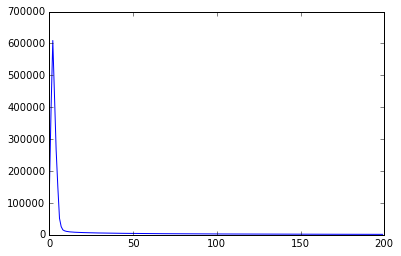

In [134]:
plt.plot(np.arange(num_epochs), train_cost)

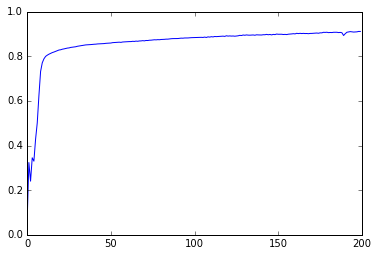

In [135]:
plt.plot(np.arange(num_epochs), train_acc)

In [136]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: train_x, Targets_nn: train_y})

0.91073334

In [137]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: valid_x, Targets_nn: valid_y})

0.85399997

In [138]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: test_x, Targets_nn: test_y})

0.85147059

##### Two layers of 500 units each

In [ ]:
hidden_units = 500

In [ ]:
W1_nn = weight_var([image_pixels, hidden_units])
W2_nn = weight_var([hidden_units, hidden_units])
W3_nn = weight_var([hidden_units, num_classes])

b1_nn = bias_var([hidden_units])
b2_nn = bias_var([hidden_units])
b3_nn = bias_var([num_classes])

In [ ]:
H1_nn = tf.nn.relu(tf.matmul(X_nn, W1_nn) + b1_nn)
H2_nn = tf.nn.relu(tf.matmul(H1_nn, W2_nn) + b2_nn)
logits_nn = tf.matmul(H2_nn, W3_nn) + b3_nn
Y_nn = tf.nn.softmax(logits_nn)

###### One layer of 1000 hidden units, with dropout

In [ ]:
keep_prob = tf.placeholder(tf.float32)
H_nn_drop = tf.nn.dropout(H_nn, keep_prob)
logits_nn = tf.matmul(H_nn_drop, W2_nn) + b2_nn

In [201]:
# feed_dict with keep_prob: 0.5

##### Hyper parameter search

In [191]:
curr_time = time()
curr_time

1455000308.827696

In [192]:
random.seed(curr_time)

In [193]:
log_learning_rate = random.uniform(-4, -2)
log_learning_rate

-2.1387102108891525

In [200]:
_learning_rate = 10 ** log_learning_rate
_learning_rate

0.0072659062354588815

In [195]:
number_layers = random.randint(1, 3)
number_layers

2

In [196]:
number_hidden_units = random.randint(100, 500)
number_hidden_units

152

In [199]:
use_dropout = (random.randint(0, 1) == 1)
use_dropout

False